In [2]:
import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import random
import itertools
from itertools import product
import networkx.algorithms.community as nx_com
import networkx as nx
import time

In [3]:
class KMeans:
    
    def __init__(self, n_clusters=8, max_iter=300,distance= "euclidean"):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.labels = []
        self.distance = distance
    
    def euclidean(self, point, data):
        return np.sqrt(np.sum((point - data)**2, axis=1))
    
    def manhattan(self, point, data):
        return np.sum(np.abs(point-data),axis=1)
    
    def call_dist(self, distance, point, data) :
        if distance == "euclidean" :
            return self.euclidean(point, data)
        else :
            return self.manhattan(point, data)
        
    def fit(self, X_train):

        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            
            # Calculate distances from points to the centroids
            dists = np.sum([ self.call_dist(self.distance,centroid, X_train) for centroid in self.centroids], axis=0)
            
            # Normalize the distances
            dists /= np.sum(dists)
            
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        
        iteration = 0
        prev_centroids = None
        
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            
            for x in X_train:
                dists = self.call_dist(self.distance, x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
            
        centroids = []
        centroid_idxs = []
        for x in X_train:
            dists = self.call_dist(self.distance,x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        
        self.labels = centroid_idxs
        

In [4]:
def modularity(G, partition):
    """Returns the modularity of the partition of an undirected graph G.
    """
    communities_sets = []
    for comm in partition:
        if comm is not None:
            communities_sets.append(frozenset(comm))
    return nx_com.modularity(G,communities_sets,weight=None)

In [5]:
class Agent:
    def __init__(self, nbr_etats: int, nbr_actions: int, alpha: float, epsilon=0.2):
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = self.creer_Q(nbr_etats, nbr_actions)
        
    def creer_Q(self, nbr_etats: int, nbr_actions: int) -> np.ndarray:
        return np.zeros((nbr_etats,nbr_actions))
    
    def exploration(self, Q: np.ndarray) -> int:
        return np.random.randint(Q.shape[1])
    
    def exploitation(self, Q: np.ndarray, etat: int) -> int:
        return np.argmax(Q[etat])
    
    def epsilon_choisir_action(self, Q: np.ndarray, etat: int, epsilon: float=0.2) -> int:
        if np.random.random() < epsilon:
            return self.exploration(Q)
        else:
            return self.exploitation(Q, etat)
        
    def mettre_ajour_Q(self, Q: np.ndarray, etat: int, netat: int, action: int, alpha: float, r: float, gamma: float) -> np.ndarray:
        new_Q = Q.copy()
        #𝑄(𝑠𝑡,𝑎𝑡)=𝑄(𝑠𝑡,𝑎𝑡)+𝛼∗(𝑟+𝛾∗max𝑎𝑄(𝑠𝑡+1,𝑎)−𝑄(𝑠𝑡,𝑎𝑡))
        new_Q[etat,action] = new_Q[etat,action] + alpha*(r + gamma * np.max(new_Q[netat]) - new_Q[etat,action])
        return new_Q

    def set_etat(self, etat: int):
        self.etat = etat
        self.action = 0
        
    def choisir_action(self):
        self.action = self.epsilon_choisir_action(self.Q, self.etat, self.epsilon)
        return self.action
    
    def appliquer(self, netat: int, action: int, r: float, gamma: float):
        self.Q = self.mettre_ajour_Q(self.Q, self.etat, netat, self.action, self.alpha, r, gamma)
        self.etat = netat

In [6]:
class QL:
    def __init__(self, graphe, k_values, distances, nb_etats, alpha: float, epsilon=0.2, gamma: float = 0.5):
        self.actions = list(itertools.product(distances, k_values))
        self.gamma = gamma
        self.g = graphe
        self.nb_etats = nb_etats
        self.ajouter_agent(alpha, epsilon)
            
        
    def ajouter_agent(self, alpha: float, epsilon=0.2):
        self.agent = Agent(self.nb_etats, len(self.actions), alpha, epsilon=epsilon)
    
    def initialiser(self):
        etat = 0
        self.agent.set_etat(etat)
    
    def calculer_recompense(self, etat: int, action: int):
        communities = self.get_partition(action)
        return modularity(self.g, communities), communities
    
    def get_partition(self, action):
        labels = []
        comm = []
        X = nx.to_numpy_array(self.g)
        distance = self.actions[action][0]
        k = self.actions[action][1]
        kmeans = KMeans(k,distance=distance)
        kmeans.fit(X)

        labels = np.array(kmeans.labels)
        for c in range(k) : 
            comm.append(np.argwhere(labels == c).flatten().tolist())
        
        return comm

    def iterate(self):
        etat = self.agent.etat
        if(etat < self.nb_etats):
            action = self.agent.choisir_action()
            r, communities = self.calculer_recompense(etat, action)
            self.agent.appliquer(self.agent.etat, action, r, self.gamma)
            self.agent.etat += 1
 
        return communities

# GANET

In [7]:
def generate_chrom_from_community(graph,community):
    
    ret = []
    
    A = nx.to_numpy_array(graph)    
    chrom = np.zeros((A.shape[0]))

    for c in community :     
        for x in c:
            rand = random.choice(c)
            #while (Adj[x,rand] != 1) or (rand not in community[i]) :
            tmp= A[x,c].flatten()
            if (len(tmp[tmp>0]) != 0):
                while (A[x,rand] <= 0):
                    rand = random.choice(c)
            else :                                # Hypothèse : this will be rendering one comm only ?? 
                while (A[x,rand] <= 0):
                    rand = random.choice(range(len(A[x])))
            chrom[x] = rand
    ret.append(chrom.astype(int))
    
    return ret

In [45]:
def community_detection(nodes,edges,k_values,alpha,beta, ql_alpha, ql_epsilon=0.2, ql_gamma=0.5,population=300,generation=30,ql_episodes=50,r=1.5):
    
    # Construction du graphe
    graph=nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    Adj = nx.adjacency_matrix(graph)
    nodes_length = len(graph.nodes())
    
    # calcul des parties des generation
    alpha_best = int(alpha * population)
    beta_kmeans = int(beta * population)
    gamma_random = population - (alpha_best + beta_kmeans)
    
    ql = QL(graph, k_values, ["euclidean","manhattan"], beta_kmeans, ql_alpha, ql_epsilon, ql_gamma)
    
    kmeans_chrom = []
    for i in range(ql_episodes):
        ql.initialiser()
        comm = None
        kmeans_chrom = kmeans_chrom + [generate_chrom_from_community(graph,ql.iterate()) for n in range(beta_kmeans)]

    kmeans_chrom_flattened = [item for sublist in kmeans_chrom for item in sublist]
    kmeans_chroms = {"chrom":kmeans_chrom_flattened}
    kmeans_chroms_dframe = pd.DataFrame(data= kmeans_chroms)
    kmeans_chroms_dframe["subsets"] = kmeans_chroms_dframe["chrom"].apply(find_subsets)
    kmeans_chroms_dframe["community_score"]=kmeans_chroms_dframe.apply(lambda x: modularity(graph,x['subsets']),axis=1)
        
    kmeans_chroms_dframe = kmeans_chroms_dframe.sort_values("community_score",ascending=False).iloc[:beta_kmeans]

#     ql.initialiser()
#     kmeans_chrom = [generate_chrom_from_community(graph,ql.iterate()) for n in range(beta_kmeans)]
    
#     kmeans_chrom_flattened = [item for sublist in kmeans_chrom for item in sublist]

    #print(len([generate_chrom(nodes_length,Adj) for n in range(population)] + kmeans_chrom_flattened),population)
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
    dframe = pd.DataFrame(data= d)
    
    
    
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
    dframe["community_score"]=dframe.apply(lambda x: modularity(graph,x['subsets']),axis=1)
    
    dframe = pd.concat([dframe, kmeans_chroms_dframe], axis=0, ignore_index=True)
    
    #print('done')
    gen = 0
    population_count = population
    results = []
    start = time.time()
    while gen < generation:
        results.append(dframe["community_score"][dframe.sort_values("community_score",ascending=False).index[0]])
        for i in range(int(np.floor(population/10))):
            p1 = 0
            p2 = 0
            elites = dframe.sort_values("community_score",ascending=True)[int(np.floor(population/10)):]
            p1 = roulette_selection(elites)
            p2 = roulette_selection(elites)
            child=uniform_crossover(dframe["chrom"][p1],dframe["chrom"][p2],0.8)
            if len(child)==0:
                continue
#             child=mutation(child,Adj,1/population)
            child=mutation(child,Adj,0.8)
            child_subsets = find_subsets(child)
            child_cs = modularity(graph,child_subsets)
            dframe.loc[population_count]=[child,child_subsets,child_cs]
            population_count += 1
        # alpha best generations
        
        dfsorted = dframe.sort_values("community_score",ascending=False)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        
        # beta from kmeans
#         kmeans_chrom = []
#         for i in range(ql_episodes):
#             ql.initialiser()
#             comm = None
#             kmeans_chrom = kmeans_chrom + [generate_chrom_from_community(graph,ql.iterate()) for n in range(beta_kmeans)]

#         kmeans_chrom_flattened = [item for sublist in kmeans_chrom for item in sublist]
#         kmeans_chroms = {"chrom":kmeans_chrom_flattened}
#         kmeans_chroms_dframe = pd.DataFrame(data= kmeans_chroms)
#         kmeans_chroms_dframe["subsets"] = kmeans_chroms_dframe["chrom"].apply(find_subsets)
#         kmeans_chroms_dframe["community_score"]=kmeans_chroms_dframe.apply(lambda x: modularity(graph,x['subsets']),axis=1)
        
#         kmeans_chroms_dframe = kmeans_chroms_dframe.sort_values("community_score",ascending=False).iloc[:beta_kmeans]

        # gamma random generations
        
#         random_dframe = dfsorted.sample(n = gamma_random)

        # concat the 3 dataframes
#         dframe = pd.concat([dframe, kmeans_chroms_dframe, random_dframe], axis=0, ignore_index=True)
        
        gen +=1        
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    five_best = dframe.sort_values("community_score",ascending=False).head(5)["community_score"]
    print(five_best)
    nodes_subsets = dframe["subsets"][sorted_df]
    nodes_list = list(graph.nodes())
    print(nodes_subsets)

    end = time.time()
    print("It Took ",end - start)
    return nodes_subsets, results

def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom

def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(sub):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
    if sum([len(c) for c in result]) != len(chrom):
        print('\n wrooooong \n',len(chrom),chrom,sub,sum([len(c) for c in result]),result)
        
    return result

def community_score(chrom,subsets,r,Adj):
    matrix = Adj.toarray()
    CS=0
    for s in subsets:
        submatrix = np.zeros((len(chrom),len(chrom)),dtype=int)
        for i in s:
            for j in s:
                submatrix[i][j]=matrix[i][j]
        M=0
        v=0
        for row in list(s):
            row_mean = np.sum(submatrix[row])/len(s)
            v+=np.sum(submatrix[row])
            M+=(row_mean**r)/len(s)
        CS+=M*v
    return CS

def roulette_selection(df_elites):
    prob = np.random.random_sample()
    sum_cs=np.sum(df_elites["community_score"])
    x=0
    selected = 0
    for i in df_elites.index:
        x += df_elites["community_score"][i]
        X=x/sum_cs
        if prob < X:
            chosen=i
            break
    return chosen

def uniform_crossover(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])

def mutation(chrom,Adj,mutation_rate):
    if np.random.random_sample() < mutation_rate:
        chrom = chrom
        neighbor = []
        while len(neighbor) < 2:
            mutant = np.random.randint(1,len(chrom))
            row = Adj[mutant].toarray()[0]
            neighbor = [i for i in range(len(row)) if row[i]==1]
            if len(neighbor) > 1:
                neighbor.remove(chrom[mutant])
                to_change=int(np.floor(np.random.random_sample()*(len(neighbor))))
                chrom[mutant]=neighbor[to_change]
                neighbor.append(chrom[mutant])
    return chrom


In [27]:
def draw_communities(G,communities, node_size=30, alpha=1, k=None, randomized=False):


    community_map = {}
    i=0
    for c in communities :
        for n in c :
            community_map[n] = i
        i+=1

    cmap = plt.get_cmap("jet")
    pos = nx.spring_layout(G)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")

    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)

# Tests

In [30]:
k_values = [3,4,5,6,7,8,9,10]

C:\Users\USER\AppData\Local\Temp/ipykernel_18064/2493264937.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(graph)


981    0.527728
552    0.523773
980    0.523773
977    0.523773
976    0.523773
Name: community_score, dtype: float64
[{0, 2, 42, 10, 28, 30, 47}, {1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60}, {3, 36, 39, 8, 59}, {4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55}, {12, 14, 16, 20, 33, 34, 37, 38, 40, 43, 44, 46, 49, 50, 52, 53, 58, 61}]
It Took  4.795078277587891


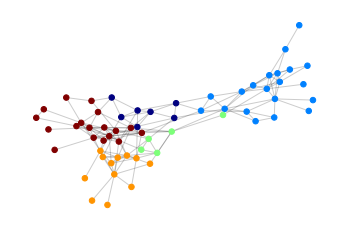

In [50]:
graph = nx.read_gml('dolphins.gml',label='id')
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,k_values=k_values,alpha=0.6,beta=0.3, ql_alpha=0.2, ql_epsilon=0.2, ql_gamma=0.3,generation=400,population=30,ql_episodes=200,r=2)
draw_communities(graph,comm[0])

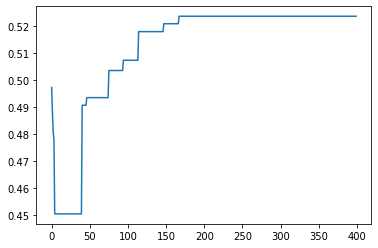

In [51]:
plt.plot(list(range(len(comm[1]))),comm[1])
plt.show()

C:\Users\USER\AppData\Local\Temp/ipykernel_18064/2493264937.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(graph)


1476    0.60457
2842    0.60457
2822    0.60457
2823    0.60457
2825    0.60457
Name: community_score, dtype: float64
[{0, 4, 69, 104, 9, 41, 11, 16, 50, 23, 24, 90, 28, 93}, {89, 1, 33, 37, 103, 105, 109, 45, 25}, {64, 32, 2, 100, 6, 39, 106, 13, 47, 15, 60}, {3, 5, 72, 74, 10, 81, 84, 98, 102, 40, 107, 52}, {68, 7, 8, 108, 77, 78, 111, 51, 21, 22}, {71, 12, 14, 18, 85, 26, 31, 34, 99, 36, 38, 42, 43, 54, 61}, {65, 70, 76, 17, 20, 87, 27, 95, 96, 97, 113, 56, 58, 59, 62, 63}, {35, 101, 79, 80, 82, 19, 30, 55, 29, 94}, {66, 75, 44, 48, 112, 86, 57, 91, 92}, {67, 73, 110, 46, 49, 114, 83, 53, 88}]
It Took  15.848261594772339


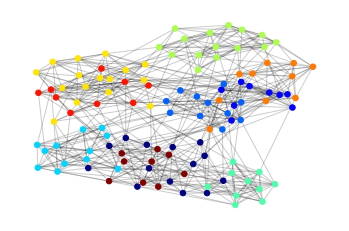

In [52]:
graph = nx.read_gml('football.gml',label='id')
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,k_values=[4,5,6,7,8,9,10],alpha=0.7,beta=0.3, ql_alpha=0.2, ql_epsilon=0.2, ql_gamma=0.5,generation=700,population=50,ql_episodes=200, r=2)
draw_communities(graph,comm[0])

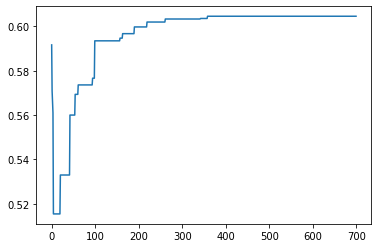

In [53]:
plt.plot(list(range(len(comm[1]))),comm[1])
plt.show()

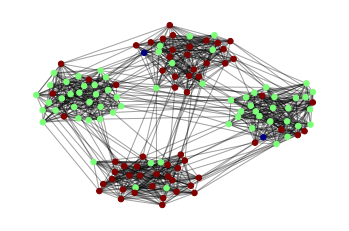

In [57]:
draw_communities(graph,comm[0])

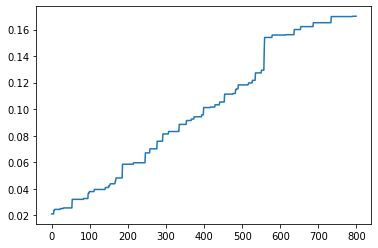

In [58]:
plt.plot(list(range(len(comm[1]))),comm[1])
plt.show()